In [1]:
# read in the test data that we are going to tokenize
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
print(f"Total chars: {len(raw_text)}")
print(raw_text[:99])


Total chars: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [7]:
# basic regex parsing
import re
text = "Hello, world. This--, is a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
print(result)
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', '--', '', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '?', '']
['Hello', ',', 'world', '.', 'This', '--', ',', 'is', 'a', 'test', '?']


In [9]:
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))
print(preprocessed[:30])

4649
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [12]:
# start converting tokens to integers
all_words = sorted(list(set(preprocessed)))
vocab_size = len(all_words)
print(vocab_size)

vocab = { token:integer for integer, token in enumerate(all_words)}
#print(vocab)
#print out the first 50
for i, item in enumerate(vocab.items()):
    print(item)
    if i > 50:
        break

1159
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Carlo;', 25)
('Chicago', 26)
('Claude', 27)
('Come', 28)
('Croft', 29)
('Destroyed', 30)
('Devonshire', 31)
('Don', 32)
('Dubarry', 33)
('Emperors', 34)
('Florence', 35)
('For', 36)
('Gallery', 37)
('Gideon', 38)
('Gisburn', 39)
('Gisburns', 40)
('Grafton', 41)
('Greek', 42)
('Grindle', 43)
('Grindle:', 44)
('Grindles', 45)
('HAD', 46)
('Had', 47)
('Hang', 48)
('Has', 49)
('He', 50)
('Her', 51)


In [15]:
# basic tokenizer class
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab #A
        self.int_to_str = { i:s for s, i in vocab.items() }

    def encode(self, text): #C
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids): #D
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #E
        return text

In [21]:
# start using the tokenizer
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," Mrs. Gisburn said """
ids = tokenizer.encode(text)
print(ids)

print(tokenizer.decode(ids))

# Key error for unknown key
#text = "Hello, do you like tea?"
#tokenizer.encode(text)

all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = { token:integer for integer, token in enumerate(all_tokens) }

print(len(vocab.items()))

for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

[1, 58, 2, 872, 1013, 615, 541, 763, 5, 1155, 608, 5, 1, 69, 7, 39, 873]
" It' s the last he painted, you know," Mrs. Gisburn said
1161
('younger', 1156)
('your', 1157)
('yourself', 1158)
('<|endoftext|>', 1159)
('<|unk|>', 1160)


In [27]:
# updated tokenizer
from typing import List
unknown_token = "<|unk|>"
eot_token = "<|endoftext|>"

class SimpleTokenizerV2:
    def __init__(self, vocab: list) -> None:
        self.str_to_int = vocab
        self.int_to_str = { i:s for s, i in vocab.items() }

    def encode(self, text: str) -> List:
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int #A
                        else unknown_token for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids: List) -> str:
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #B
        return text


In [29]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = f" {eot_token} ".join((text1, text2))
print(text)
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))


Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1160, 5, 362, 1155, 642, 1000, 10, 1159, 57, 1013, 981, 1009, 738, 1013, 1160, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


In [31]:
# now we can just use a python lib of a more sophisticated tokenizer
# poetry add tiktoken, and checking the version here.
from importlib.metadata import version
import tiktoken
print("tiktoken version: ", version("tiktoken"))

tiktoken version:  0.9.0


In [34]:
tokenizer = tiktoken.get_encoding("gpt2")
text = f"Hello, do you like tea? {eot_token} In the sunlit terra"
integers = tokenizer.encode(text, allowed_special={eot_token})
print(integers)
strings = tokenizer.decode(integers)
print(strings)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 1059, 430]
Hello, do you like tea? <|endoftext|> In the sunlit terra


In [43]:
# Tokenize the input text so we can muck around with a sliding window
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

# remove some 50 entries to make things interesting
enc_sample = enc_text[50:]

# creating the sliding window (x / y shifted by 1)
# to create input/target pairs for next word prediction
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"\ty: {y}")

for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    # everything to the left represents the input the LLM would recieve
    print(context, "---->", desired)


# same test but converted ids back to strings
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

5145
x: [290, 4920, 2241, 287]
	y: [4920, 2241, 287, 257]
[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257
 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [74]:
# installed torch rocm version
# poetry run pip3 install torch --index-url https://download.pytorch.org/whl/rocm6.2.4
import torch
print(dir(torch.backends))
torch.__version__
tensor0d = torch.tensor(1) #A
tensor1d = torch.tensor([1, 2, 3]) #B
tensor2d = torch.tensor([[1, 2], [3, 4]]) #C
tensor3d = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]]) #D
print(tensor0d)
print(tensor1d)
print(tensor2d)
print(tensor3d)

['ContextProp', 'PropModule', '__allow_nonbracketed_mutation', '__allow_nonbracketed_mutation_flag', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'contextmanager', 'cpu', 'cuda', 'cudnn', 'cusparselt', 'disable_global_flags', 'flags_frozen', 'mha', 'mkl', 'mkldnn', 'mps', 'nnpack', 'openmp', 'quantized', 'types']
tensor(1)
tensor([1, 2, 3])
tensor([[1, 2],
        [3, 4]])
tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])


In [52]:
from torch.utils.data import Dataset, DataLoader

# Dataset class
class GPTDatasetV1(Dataset):
    def __init__(self, txt: str, tokenizer, max_length:int, stride:int) -> None:
        # stride is how many positions we shift the sliding window, if stride == window size
        # we can eliminate the overlap in batches
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) # A

        for i in range(0, len(token_ids) - max_length, stride): # B
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self): #C
        return len(self.input_ids)

    def __getitem__(self, idx): # D
        return self.input_ids[idx], self.target_ids[idx]



In [63]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2") # A
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # B
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader

dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader) # A
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)



[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [71]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
# without overlap since we are doing max 4 / stride 4
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [76]:
# trying to figure out what autograd is, to do backpropagation
# so that we can compute the gradient of the loss 
import torch.nn.functional as F
from torch.autograd import grad
y = torch.tensor([1.0]) # target
x1 = torch.tensor([1.1])   # input
w1 = torch.tensor([2.2], requires_grad=True) #trainable weight param
b = torch.tensor([0.0], requires_grad=True)  #trainable bias unit
z = x1 * w1 + b
a = torch.sigmoid(z)
loss = F.binary_cross_entropy(a, y)
grad_L_w1 = grad(loss, w1, retain_graph=True) #A
grad_L_b = grad(loss, b, retain_graph=True)
#Let's show the resulting values of the loss with respect to the model's
#parameters:
print(grad_L_w1)
print(grad_L_b)

# or pytorch just has this built in as .backward()
loss.backward()
print(w1.grad)
print(b.grad)

(tensor([-0.0898]),)
(tensor([-0.0817]),)
tensor([-0.0898])
tensor([-0.0817])


In [80]:
# setup a very small embedding space to muck around
input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6 # BPE has 50k words (the gpt2 encoder use use above) BytePair Encoding (breaks down words to smaller tokens to handle unknowns)
output_dim = 3  # GPT-3 has an embedding size 12,288 dimentions for reference
torch.manual_seed(123) #set seed manually for reproducible results
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)
# apply it to a token to get the embedding vector
print(embedding_layer(torch.tensor([3])))
# apply it to all our ids
print(embedding_layer(input_ids))

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


In [88]:
# Now we can start creating the token "embeddings" / vectors

#create more realistic dimensions
output_dim = 256
vocab_size = 50257
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# absolute embedding approach
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])
torch.Size([8, 4, 256])
torch.Size([4, 256])
torch.Size([8, 4, 256])


In [99]:
# starting with attention
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

query = inputs[1] #A
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

# dot product
res = 0.
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
print(res)
print(torch.dot(inputs[0], query))
# higher dot.product is the more similar the vectors

attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum() # normalization of the results
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())  # do normalization so all the sum == 1.

# normalization usually done with softmax, here's a naive implementation

def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)
attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

# pytorch also supports this directly
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

# now get the context vector
query = inputs[1] # 2nd input token is the query
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

# compute dot.product for all input pairs
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
tensor(0.9544)
tensor(0.9544)
Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
tensor([0.4419, 0.6515, 0.5683])


In [106]:
# actual attention here


# 1
attn_scores = inputs @ inputs.T # matrix mult with numpy operator
print(attn_scores)

#2
attn_weights = torch.softmax(attn_scores, dim=1)
print(attn_weights)

# test to make sure normalization still == 1
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=1))

# 3
# compute all context vectors 
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)
# just validating result
print("Previous 2nd context vector:", context_vec_2)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])
Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
Previous 2n

In [112]:
# attention with trainable weights
x_2 = inputs[1] #A
d_in = inputs.shape[1] #B
d_out = 2 #C

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False) # would be True if we were doing training
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)


# Weight paramaters that are trained (learned coefficients that define the networks connections), 
# which are different from the contextual attention"weights" in previous sections
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys_2 = keys[1] #A
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

# scaling by the square root of the embedding dimension is the reason why
# this self-attention mechanism is also called scaled-dot product attention
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1) # **0.5 == sqrt shorthand
print(attn_weights_2)

# calc context_vect_2
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.4306, 1.4551])
keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])
tensor(1.8524)
tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])
tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
tensor([0.3061, 0.8210])


In [117]:
# self attention class

import torch.nn as nn

class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attention_scores = queries @ keys.T # omega
        attention_weights = torch.softmax(attention_scores/ keys.shape[-1]**0.5, dim=-1)
        context_vector = attention_weights @ values
        return context_vector

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

# better optimized with some pytorch builtin

class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(attention_scores / keys.shape[-1]**0.5, dim=-1)
        context_vector = attn_weights @ values
        return context_vector

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)
tensor([[-0.0858,  0.0607],
        [-0.0921,  0.0578],
        [-0.0912,  0.0588],
        [-0.0885,  0.0572],
        [-0.0689,  0.0845],
        [-0.0973,  0.0461]], grad_fn=<MmBackward0>)


In [119]:
#  bonus stuff from chap3
# Suppose we have the following 3 training examples,
# which may represent token IDs in a LLM context
idx = torch.tensor([2, 3, 1])

# The number of rows in the embedding matrix can be determined
# by obtaining the largest token ID + 1.
# If the highest token ID is 3, then we want 4 rows, for the possible
# token IDs 0, 1, 2, 3
num_idx = max(idx)+1

# The desired embedding dimension is a hyperparameter
out_dim = 5
# We use the random seed for reproducibility since
# weights in the embedding layer are initialized with
# small random values
torch.manual_seed(123)

embedding = torch.nn.Embedding(num_idx, out_dim)


In [120]:
embedding.weight

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  1.5810],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015],
        [ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953]], requires_grad=True)

In [121]:
embedding(torch.tensor([1]))


tensor([[ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

In [122]:
embedding(torch.tensor([2]))

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315]],
       grad_fn=<EmbeddingBackward0>)

In [123]:
idx = torch.tensor([2, 3, 1])
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

In [124]:
onehot = torch.nn.functional.one_hot(idx)
onehot

tensor([[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]])

In [127]:
torch.manual_seed(123)
linear = torch.nn.Linear(num_idx, out_dim, bias=False)
linear.weight

Parameter containing:
tensor([[-0.2039,  0.0166, -0.2483,  0.1886],
        [-0.4260,  0.3665, -0.3634, -0.3975],
        [-0.3159,  0.2264, -0.1847,  0.1871],
        [-0.4244, -0.3034, -0.1836, -0.0983],
        [-0.3814,  0.3274, -0.1179,  0.1605]], requires_grad=True)

In [130]:
linear.weight = torch.nn.Parameter(embedding.weight.T)
linear(onehot.float())

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]], grad_fn=<MmBackward0>)

In [131]:
embedding(idx)

tensor([[ 0.6957, -1.8061, -1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010, -0.1606, -0.4015]],
       grad_fn=<EmbeddingBackward0>)

In [132]:
# End of chapter 3 bonus stuff

In [138]:
# causal *masked* attention only considers the previous and currents input in a seqenence

queries = sa_v2.W_query(inputs) #A
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)


# create the mask with pytorch's tril
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

masked_simple = attn_weights*mask_simple
print(masked_simple)

# renorm

row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)


# more pytorch optimizations
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.0000

In [141]:
# Dropout (to reduce overfitting) only ever used "during" training
# drop out 50% for playing around

torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #A
example = torch.ones(6, 6) #B
print(dropout(example))

# apply drop out mask to Attention Weights
torch.manual_seed(123)
print(dropout(attn_weights))

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) #A

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
torch.Size([2, 6, 3])


In [143]:
# causal attention class

class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) #A
        self.register_buffer('mask',torch.triu(torch.ones(context_length, context_length),diagonal=1)) #B
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape #C
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.transpose(1, 2) #C
        attn_scores.masked_fill_( #D
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [195]:
#2
class Ch03_MHA(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


mha_ch03 = Ch03_MHA(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_ch03(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


In [157]:
# Multi-head class

class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )
        self.out_proj = nn.Linear(d_out*num_heads, d_out*num_heads)

    def forward(self, x):
        context_vec = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.out_proj(context_vec)

# test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(device)
batch_size = 8
context_len = 1024
embed_dim = 768
embeddings = torch.randn((batch_size, context_len, embed_dim), device=device)
mh = MultiHeadAttentionWrapper(
    d_in=embed_dim,
    d_out=embed_dim//12,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mh(embeddings)
print(out.shape)

PyTorch version: 2.6.0+rocm6.2.4
cuda
torch.Size([8, 1024, 768])


In [182]:
import math


class MHAEinsum(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # Initialize parameters for Q, K, V
        self.W_query = nn.Parameter(torch.randn(d_out, d_in))
        self.W_key = nn.Parameter(torch.randn(d_out, d_in))
        self.W_value = nn.Parameter(torch.randn(d_out, d_in))

        if qkv_bias:
            self.bias_q = nn.Parameter(torch.zeros(d_out))
            self.bias_k = nn.Parameter(torch.zeros(d_out))
            self.bias_v = nn.Parameter(torch.zeros(d_out))
        else:
            self.register_parameter("bias_q", None)
            self.register_parameter("bias_k", None)
            self.register_parameter("bias_v", None)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

        # Initialize parameters
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_query, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_key, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_value, a=math.sqrt(5))
        if self.bias_q is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_query)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias_q, -bound, bound)
            nn.init.uniform_(self.bias_k, -bound, bound)
            nn.init.uniform_(self.bias_v, -bound, bound)

    def forward(self, x):
        b, n, _ = x.shape

        # Calculate Q, K, V using einsum, first perform linear transformations
        Q = torch.einsum("bnd,di->bni", x, self.W_query)
        K = torch.einsum("bnd,di->bni", x, self.W_key)
        V = torch.einsum("bnd,di->bni", x, self.W_value)

        # Add biases if they are used
        if self.bias_q is not None:
            Q += self.bias_q
            K += self.bias_k
            V += self.bias_v

        # Reshape for multi-head attention
        Q = Q.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.einsum("bhnd,bhmd->bhnm", Q, K) / (self.head_dim ** 0.5)

        # Apply mask
        mask = self.mask[:n, :n].unsqueeze(0).unsqueeze(1).expand(b, self.num_heads, n, n)
        scores = scores.masked_fill(mask.bool(), -torch.inf)

        # Softmax and dropout
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Aggregate the attended context vectors
        context_vec = torch.einsum("bhnm,bhmd->bhnd", attn_weights, V)

        # Combine heads and project the output
        context_vec = context_vec.transpose(1, 2).reshape(b, n, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec


mha_einsum = MHAEinsum(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_einsum(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


In [152]:
# different implementation that does combining all weights in a single pass
class MultiHeadAttentionCombinedQKV(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_head, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)

        # (b, num_heads, num_tokens, head_dim) --> (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(-2, -1)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**-0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # (b, num_heads, num_tokens, num_tokens) --> (b, num_heads, num_tokens, head_dim)
        context_vec = attn_weights @ values

        # (b, num_heads, num_tokens, head_dim) --> (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)

        # (b, num_tokens, num_heads, head_dim) --> (b, num_tokens, embed_dim)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)

        context_vec = self.proj(context_vec)

        return context_vec


mha_combined_qkv = MultiHeadAttentionCombinedQKV(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_combined_qkv(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


In [188]:
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec
        
mha_pytorch_scaled = MHAPyTorchScaledDotProduct(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_scaled(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


In [190]:
class MHAPyTorchSDPAWithoutFlash(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=attn_mask, dropout_p=use_dropout, is_causal=False)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec
        
mha_pytorch_sdpa_no_flash = MHAPyTorchSDPAWithoutFlash(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_sdpa_no_flash(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


In [191]:
class MHAPyTorchClass(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False, need_weights=True):
        super().__init__()

        self.context_length = context_length
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_out,
            num_heads=num_heads,
            dropout=dropout,
            bias=qkv_bias,
            add_bias_kv=qkv_bias,
            batch_first=True,
        )

        self.need_weights = need_weights
        self.proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, _ = x.shape

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        # attn_mask broadcasting will handle batch_size dimension implicitly
        attn_output, _ = self.multihead_attn(
            x, x, x, attn_mask=attn_mask, need_weights=self.need_weights
        )

        output = self.proj(attn_output)

        return output


mha_pytorch_class_default = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_class_default(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


In [193]:
#8
mha_pytorch_class_noweights = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False,
    need_weights=False # NEW!
).to(device)

out = mha_pytorch_class_noweights(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


In [194]:
# 9
from packaging.version import parse as parse_version

def normalize_version(version):
    parsed_version = parse_version(version)
    return parse_version(f"{parsed_version.major}.{parsed_version.minor}.{parsed_version.micro}")

current_version = normalize_version(torch.__version__)
MIN_TORCH_VERSION = "2.5.0"
required_version = parse_version(MIN_TORCH_VERSION)
if current_version >= required_version:
    from torch.nn.attention.flex_attention import flex_attention, create_block_mask


def causal(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx


class MHAPyTorchFlexAttention(nn.Module):

    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        # self.register_buffer("block_mask", create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length))
        # `create_block_mask` function does not support buffers, yet
        self.block_mask = create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length)


    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        # use_dropout = 0. if not self.training else self.dropout

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.block_mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.block_mask[:self.context_length, :self.context_length]

        context_vec = flex_attention(queries, keys, values, block_mask=attn_mask)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec
        
if current_version >= required_version and torch.cuda.is_available():

    mha_pytorch_flex = MHAPyTorchFlexAttention(
        d_in=embed_dim,
        d_out=embed_dim,
        context_length=context_len,
        dropout=0.0,
        num_heads=12,
        qkv_bias=False
    ).to(device)

    out = mha_pytorch_flex(embeddings)
    print(out.shape)


torch.Size([8, 1024, 768])


In [189]:
# some benchmarking to figure out what works well on my 7900xtx
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')  # optimization was spit out by a pytorch warning
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.6.0+rocm6.2.4
Running on cuda


In [177]:
## 1) CausalAttention MHA wrapper class from chapter 3
%timeit mh(embeddings)

14.2 ms ± 605 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [196]:
## 2) The multi-head attention class from chapter 3
%timeit mha_ch03(embeddings)

6.2 ms ± 203 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [179]:
## 3) An alternative multi-head attention with combined weights
%timeit mha_combined_qkv(embeddings)

7.4 ms ± 164 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [183]:
## 4) Multi-head attention using Einstein summation
%timeit mha_einsum(embeddings)

8.2 ms ± 245 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [197]:
## 5) Multi-head attention with PyTorch's scaled dot product attention
%timeit mha_pytorch_scaled(embeddings)

4.85 ms ± 430 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [198]:
## 6) PyTorch's scaled dot product attention without FlashAttention
%timeit mha_pytorch_sdpa_no_flash(embeddings)

7.04 ms ± 350 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [199]:
## 7) Using PyTorch's torch.nn.MultiheadAttention
%timeit mha_pytorch_class_default(embeddings)

6.86 ms ± 174 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [200]:
## 8) Using PyTorch's torch.nn.MultiheadAttention disabling `need_weights`
%timeit mha_pytorch_class_noweights(embeddings)

7.65 ms ± 282 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [164]:
# 9) Using PyTorch's FlexAttention
%timeit mha_pytorch_flex(embeddings)

16.4 ms ± 47.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [201]:
import matplotlib.pyplot as plt

functions = {
    "1) MHA wrapper class": mh,
    "2) MHA Ch03": mha_ch03,
    "3) MHA with combined QKV weights": mha_combined_qkv,
    "4) MHA with Einsum": mha_einsum,
    "5) MHA with PyTorch scaled_dot_product_attention": mha_pytorch_scaled,
    "6) PyTorch's SDPA, no FlashAttention": mha_pytorch_sdpa_no_flash,
    "7) PyTorch MHA class defaults": mha_pytorch_class_default,
    "8) PyTorch MHA with need_weights=False": mha_pytorch_class_noweights
    }

if current_version >= required_version:
    functions["8) PyTorch's FlexAttention"] =  mha_pytorch_flex
    
# Customize further for dark mode aesthetics
plt.rcParams["figure.facecolor"] = "#121212"
plt.rcParams["axes.facecolor"] = "#121212"
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["text.color"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["grid.color"] = "#444444"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8

def plot_execution_times(functions, execution_means, execution_stds, filename):

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(functions.keys(), execution_means, yerr=execution_stds, capsize=5, error_kw={'ecolor': 'grey'})

    plt.ylabel("Execution time (ms)")
    plt.xticks(rotation=45, ha="right")

    # Calculate new ylim with a margin
    max_execution_time = max(execution_means)
    upper_ylim = max_execution_time + 0.4 * max_execution_time  # Adding a 40% margin
    plt.ylim(0, upper_ylim)

    # Annotate bars with execution times
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.05 * upper_ylim), round(yval, 2), ha="center", va="bottom")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [202]:
import numpy as np

def time_pytorch_function(func, *input, num_repeats=1_000):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        func(*input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        func(*input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)


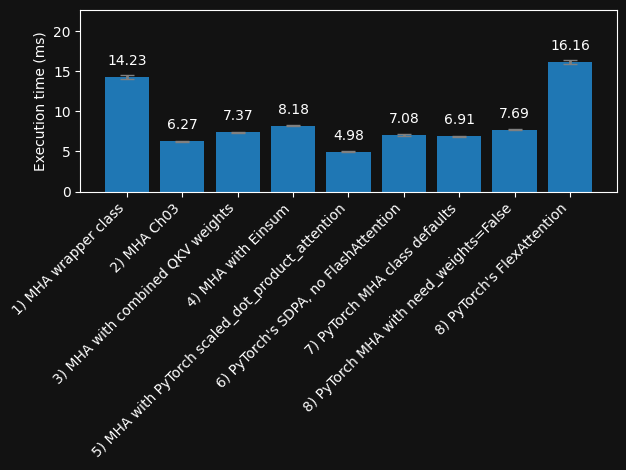

In [203]:
execution_stats = [time_pytorch_function(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="1_forward-only.pdf")

In [204]:
def forward_backward(func, embeddings):
    if embeddings.grad is not None:
        embeddings.grad.zero_()

    output = func(embeddings)
    loss = output.sum()
    loss.backward()


def time_pytorch_function_forward_backward(func, *input, num_repeats = 1_000):
    # CUDA IS ASYNC so can't use python time module
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        forward_backward(func, *input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        forward_backward(func, *input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)

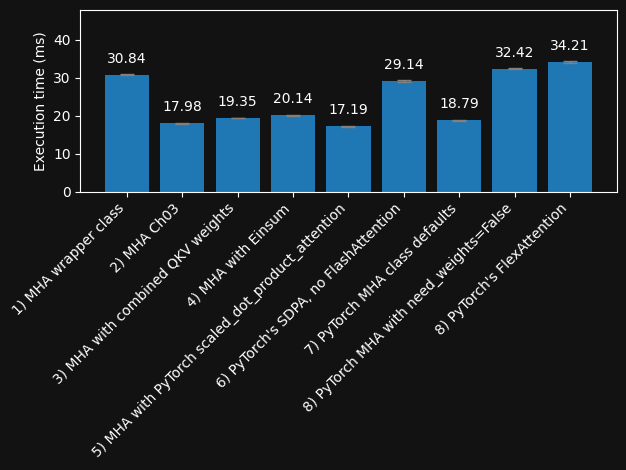

In [205]:
execution_stats = [time_pytorch_function_forward_backward(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="2_forward-and-backward.pdf")

In [207]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

def prepare_function(fn):
    fn = torch.compile(fn)
    return fn


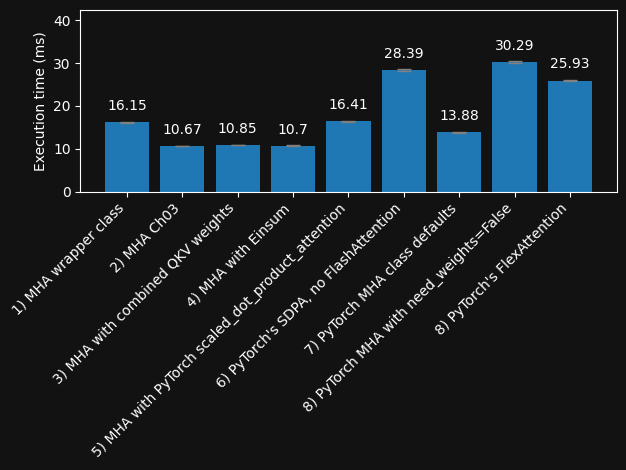

In [208]:
execution_stats = [time_pytorch_function_forward_backward(prepare_function(fn), embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="3_forward-and-backward-compiled.pdf")

